In [ ]:
#### Install dependenses

In [ ]:
%pip install napari

In [ ]:
%pip install monai

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import napari
# import patoolib
import zipfile
import os
import re
import tqdm
from monai.transforms import (
    Compose, LoadImaged, Spacingd, NormalizeIntensityd, SpatialPadd,
    RandCropByPosNegLabeld, RandRotated, RandFlipd, RandAdjustContrastd,
    RandShiftIntensityd, RandGaussianNoised, RandScaleIntensityd, RandZoomd,
    RandAffined, AsDiscrete
)
from monai import (
    data,
    transforms,
)
from cldice import soft_dice_cldice, soft_dice
from unet_block import UNet3D
from monai.data import (
    ArrayDataset,
    DataLoader,
    create_test_image_3d,
    decollate_batch,
)
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
import torch.optim as optim
from IPython.display import clear_output
from train_val import train, validation, plot_train_history, plot_sample

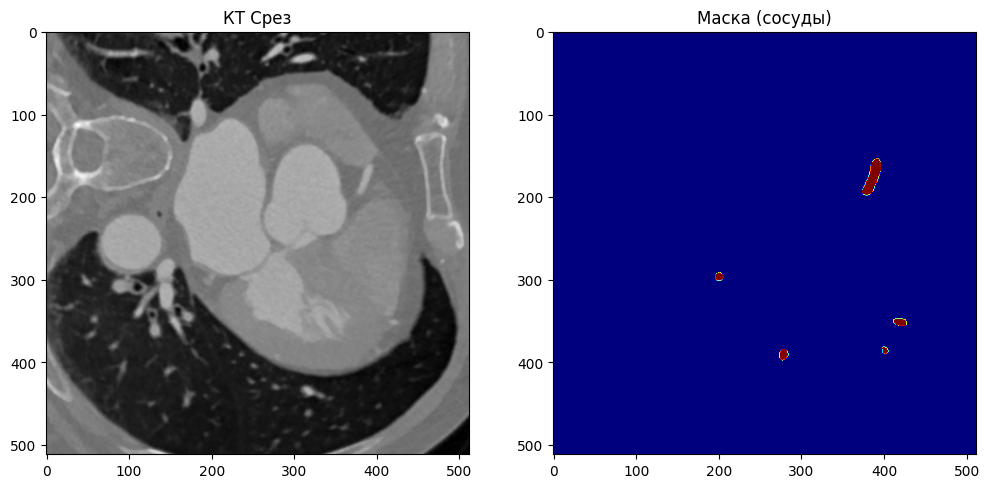

In [29]:
# Путь к файлу (замените на свой)
image_path = './data/1-200/1.img.nii.gz'
label_path = './data/1-200/1.label.nii.gz'

# Загрузка
img = nib.load(image_path)
label = nib.load(label_path)

# Преобразование в numpy-массив
img_data = img.get_fdata()
label_data = label.get_fdata()

# Выбор центрального среза по оси Z
slice_idx = img_data.shape[2] // 2

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("КТ Срез")
plt.imshow(img_data[:, :, slice_idx], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Маска (сосуды)")
plt.imshow(label_data[:, :, slice_idx], cmap='jet')

plt.show()

##### Готовим данные для нейросети

In [30]:
def download_data(path):
    data = []
    for dir in path:
        start, end = dir.split('-')
        for i in tqdm.tqdm(range(int(start), int(end)+1)):
            img_path = f'./data/{dir}/{i}.img.nii.gz'
            seg_path = f'./data/{dir}/{i}.label.nii.gz'
            img = torch.tensor(nib.load(img_path).get_fdata(), dtype=torch.float).unsqueeze(0)
            seg = torch.tensor(nib.load(seg_path).get_fdata(), dtype=torch.float).unsqueeze(0)
            
            data.append({"image": img, "label": seg})
    
    return data

In [3]:
# dirs = ['1-200'] # test dataset
dirs = ['1-200', '201-400', '401-600', '601-800', '801-1000']

images, segs = [], []
for dir in dirs:
    start, end = dir.split('-')
    images += [f'./data/{dir}/{i}.img.nii.gz' for i in range(int(start), int(end)+1)]

for dir in dirs:
    start, end = dir.split('-')
    segs += [f'./data/{dir}/{i}.label.nii.gz' for i in range(int(start), int(end)+1)]

In [4]:
dataset = [{"image": img, "label": lbl} for img, lbl in zip(images, segs)]

In [5]:
train_ratio = 0.8
train_size = int(len(dataset) * train_ratio)
val_size = len(dataset) - train_size
train_files, validation_files = random_split(dataset, [train_size, val_size])

In [6]:
roi = (96, 96, 96)

base_transform = [transforms.LoadImaged(keys=["image", "label"], ensure_channel_first=True), # LoadImaged - 
        transforms.Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")), # Spacingd - 
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True), # NormalizeIntensityd - стандартная нормализация значений каналов изображения 
        transforms.SpatialPadd(keys=["image", "label"], spatial_size=roi),] # SpatialPadd - заполнить изображение до заданного roi

num_crop_samples = 3
train_transform = [transforms.RandCropByPosNegLabeld(
                           keys=["image", "label"], 
                           label_key="label",
                           spatial_size=roi,
                           num_samples=num_crop_samples,
                           image_key="image",
                           allow_smaller=True)] 

In [7]:
aug_transform = [    
    
    # === Геометрические аугментации ===
    RandRotated(
        keys=["image", "label"],
        range_x=np.pi/6,
        range_y=np.pi/6,
        range_z=np.pi/6,
        prob=0.3,
        mode=("bilinear", "nearest"),
        align_corners=True
    ),
    RandFlipd(keys=["image", "label"], spatial_axis=0, prob=0.3),
    RandFlipd(keys=["image", "label"], spatial_axis=1, prob=0.3),
    RandFlipd(keys=["image", "label"], spatial_axis=2, prob=0.3),

    # === Дополнительные геометрические трансформации ===
    RandZoomd(
        keys=["image", "label"],
        min_zoom=0.9,
        max_zoom=1.1,
        mode=("trilinear", "nearest"),
        align_corners=(True, None),
        prob=0.3
    ),
    RandAffined(
        keys=["image", "label"],
        rotate_range=(0.1, 0.1, 0.1),
        scale_range=(0.1, 0.1, 0.1),
        translate_range=(5, 5, 5),
        prob=0.3,
        mode=("bilinear", "nearest"),
        padding_mode="border"
    ),

    # === Фотометрические трансформации (только для изображения) ===
    RandAdjustContrastd(
        keys=["image"],
        gamma=(0.7, 1.5),
        prob=0.3
    ),
    RandShiftIntensityd(
        keys=["image"],
        offsets=0.1,
        prob=0.3
    ),
    RandScaleIntensityd(
        keys=["image"],
        factors=0.1,
        prob=0.3
    ),
    RandGaussianNoised(
        keys=["image"],
        std=0.05,
        prob=0.3
    ),]

In [8]:
train_transform = transforms.Compose(base_transform + train_transform + aug_transform)

train_ds = data.Dataset(data=train_files, transform=train_transform)

train_loader = data.DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)

In [9]:
val_transform = transforms.Compose(base_transform)

val_ds = data.Dataset(data=validation_files, transform=val_transform)

val_loader = data.DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

#### Обучение и валидация модели

In [ ]:
import torch
import gc

gc.collect()

torch.cuda.empty_cache()

In [12]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

In [13]:
model = UNet3D(in_channels=1, out_channels=2, final_sigmoid=False, f_maps=64, num_levels=4)
# model = UNet(spatial_dims=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 32, 64),
#     strides=(2, 2, 2),
#     num_res_units=2,
#     kernel_size=3,
#     up_kernel_size=3,
#     norm='batch').to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_function = soft_dice_cldice(alpha=0.3)
scaler = torch.amp.GradScaler()

In [12]:
device=None
device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
if torch.cuda.device_count() > 1:
    print(f"Используем {torch.cuda.device_count()} GPU!")
    model = nn.DataParallel(model)

In [41]:
model.to(device)

def count_parameters(model):
    # Все параметры
    total_params = sum(p.numel() for p in model.parameters())
    
    # Только обучаемые (у которых градиент включен)
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Всего параметров: {total_params:,}")
    print(f"Обучаемых параметров: {trainable_params:,}")
    
    # Бонус: сколько они весят в МБ (для float32)
    print(f"Размер модели (только веса): {total_params * 4 / (1024**2):.2f} MB")

# Использование
count_parameters(model)

Всего параметров: 16,318,756
Обучаемых параметров: 16,318,756
Размер модели (только веса): 62.25 MB


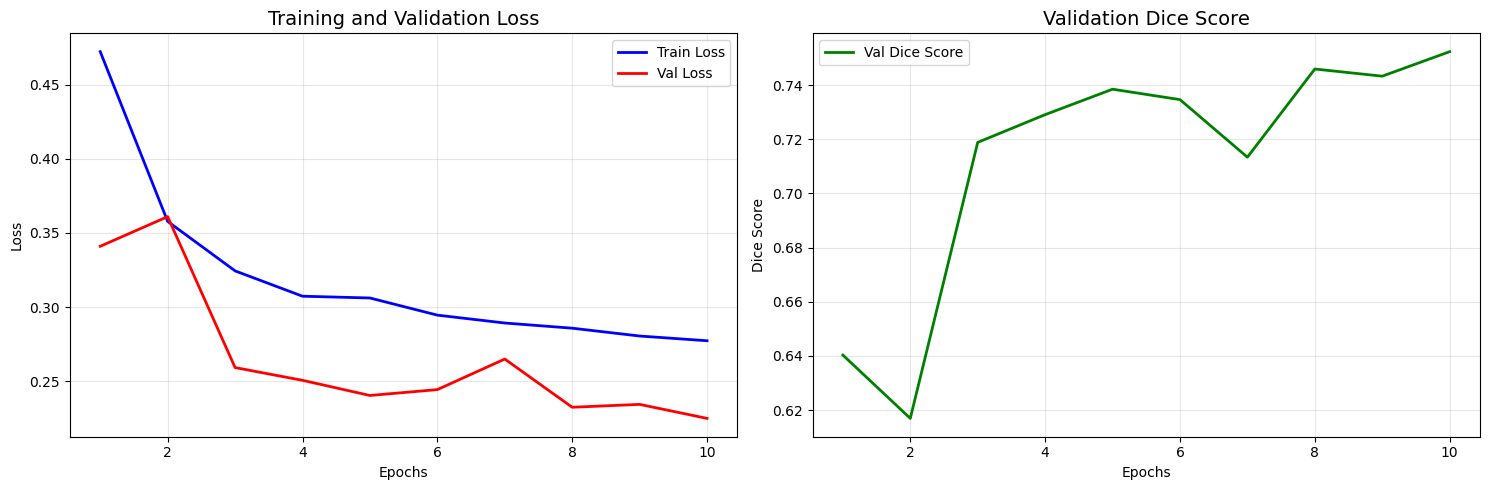

In [47]:
train(model, loss_function, optimizer, train_loader, val_loader, 10, True, scaler, device)

In [18]:
model = UNet3D(in_channels=1, out_channels=2, final_sigmoid=False, f_maps=64, num_levels=4).to(device)
model.load_state_dict(torch.load('model_weights.pth', map_location=device))

<All keys matched successfully>

In [17]:
validation(model, loss_function, val_loader, device)

100%|██████████| 200/200 [04:16<00:00,  1.28s/it]


(0.22576772086322308, 0.7514214339852333)

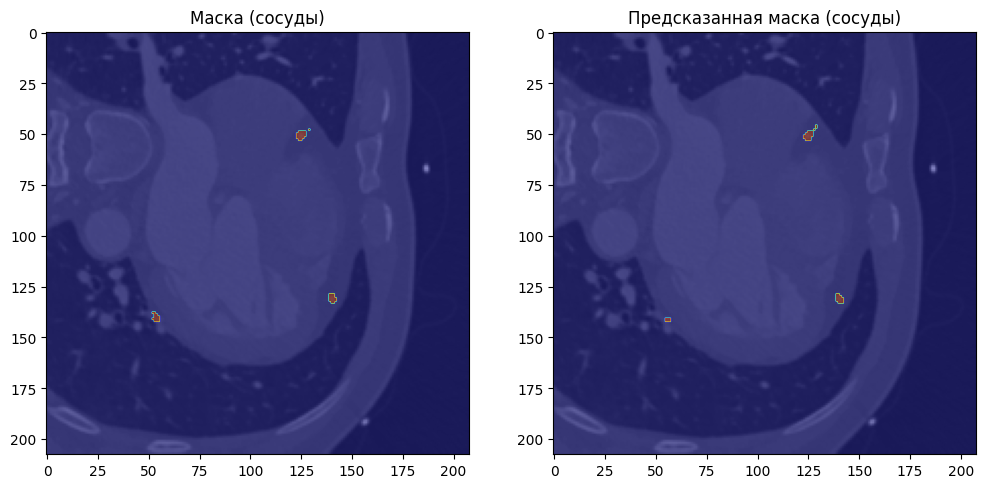

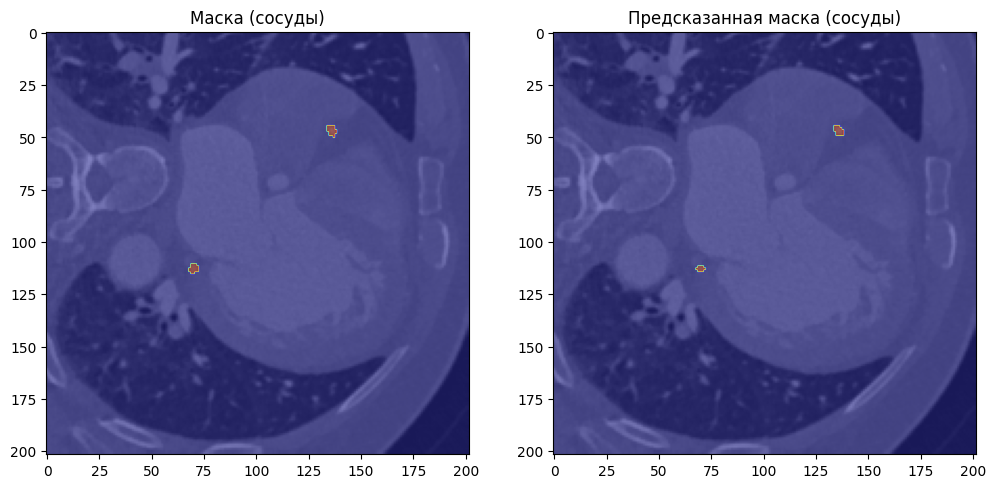

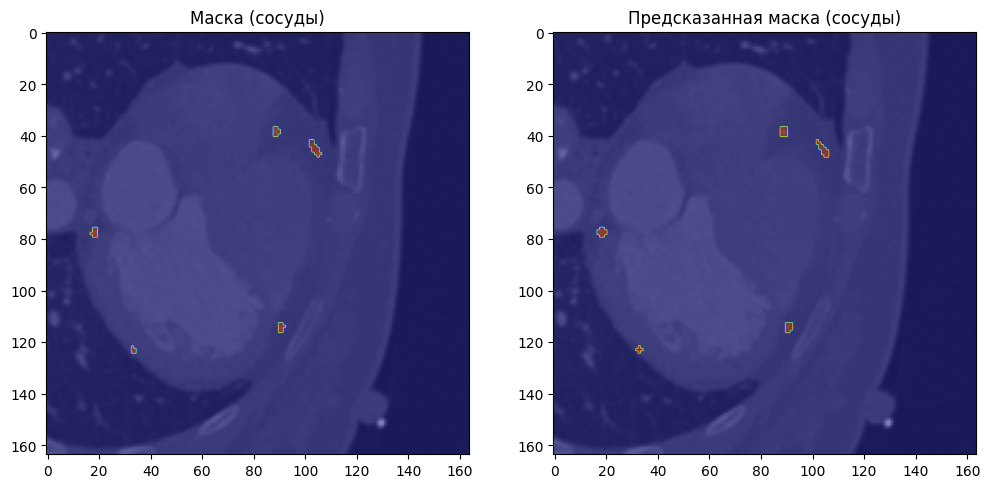

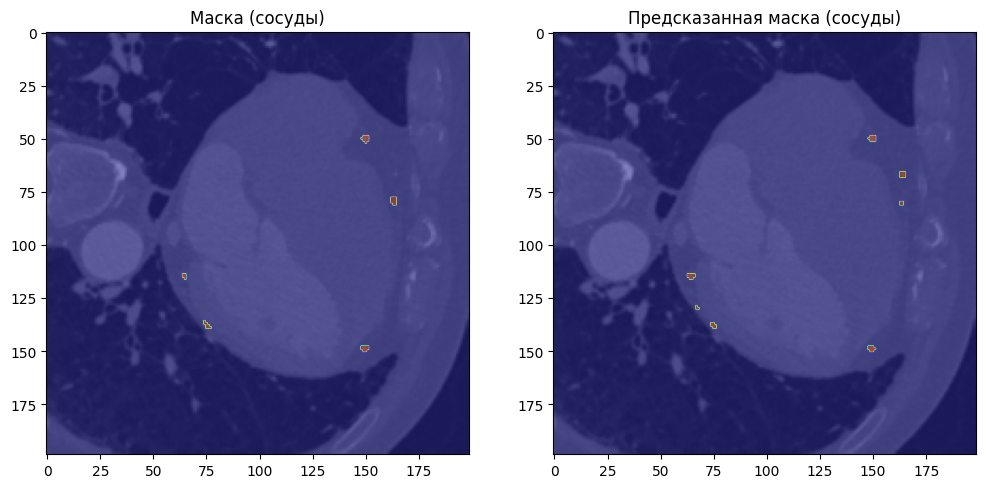

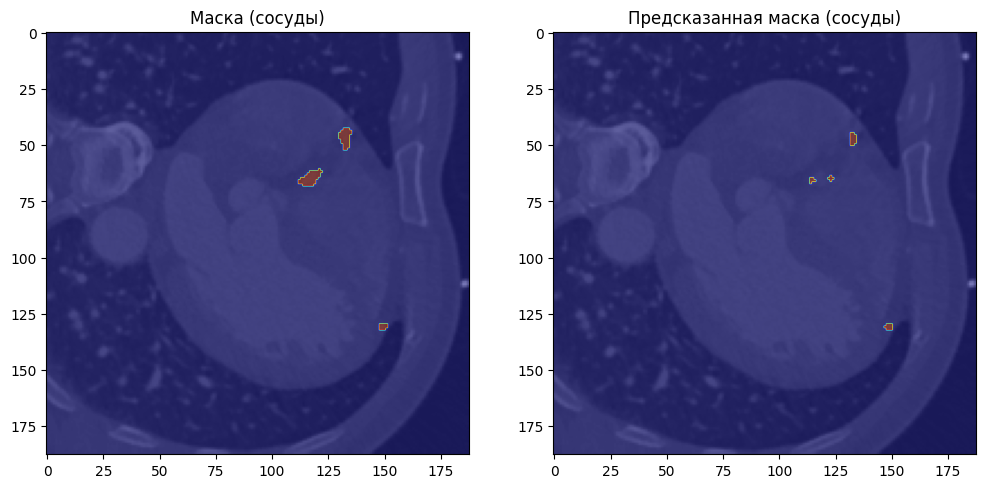

In [27]:
plot_sample(5, model, val_loader, device)